In [68]:
from itertools import product
from pathlib import Path
from typing import Any, Dict, Optional, Tuple

import numpy as np
import polars as pl
import yaml
from xlsxwriter import Workbook
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
def place_student(
    room_dict: Dict[str, np.ndarray], student_id: int, room_name: Optional[str] = None
) -> Tuple[int, int]:
    if room_name is None:
        room_name = [k for k, m in room_dict.items() if (m == 1).sum() > 0][0]
    room_matrix = room_dict[room_name]
    # Find first available sit
    r, c = np.where(room_matrix == 1)
    if len(r) == 0:
        raise ValueError("No more sits available")
    room_matrix[r[0], c[0]] = student_id
    return {"room": room_name, "row": r[0], "col": c[0]}

In [70]:
def build_room_matrix(config: Dict[str, Any]) -> np.ndarray:
    matrix = np.zeros((config["size"]["rows"], config["size"]["cols"]), dtype=np.int64)
    for r, c in product(config["sits"]["rows"], config["sits"]["cols"]):
        matrix[r, c] = 1
    # Banned areas
    for range in config["banned_sits"]:
        start = list(map(int, range["start"].split(":")))
        end = list(map(int, range["end"].split(":")))
        banned_range = (*start, *end)
        matrix[
            banned_range[0] : banned_range[2] + 1, banned_range[1] : banned_range[3] + 1
        ] = -1
    # Desk
    start = list(map(int, config["desk"]["start"].split(":")))
    end = list(map(int, config["desk"]["end"].split(":")))
    matrix[start[0] : end[0] + 1, start[1] : end[1] + 1] = -2
    return matrix

In [71]:
FOLDER = Path(".")
ROOMS = ["R3"]
NOPC_STUDENTS = []
NOPC_ROOM = "5T"
DSA_ROOM = "R3"

In [72]:
# Read prenatati
prenotati = pl.scan_csv(FOLDER / "VISAP_Elenco_Studenti_*").collect()
if prenotati.is_duplicated().any():
    print("Attenzione: studenti duplicati nella tabella\n")
    prenotati = prenotati.unique()

prenotati = prenotati.select("MATRICOLA", "COGNOME", "NOME", "DOCENTE", "NOTE").sort(
    "COGNOME"
)
# DSA students
dsa = prenotati.filter(
    pl.col("NOTE").str.contains("Dsa") | pl.col("NOTE").str.contains("Tempo aggiuntivo")
).get_column("MATRICOLA")

on_site = (
    prenotati.filter(
        pl.col("NOTE").str.contains("Esame online").not_()
        | pl.col("NOTE").is_null()
    )
    .filter(pl.col("MATRICOLA").is_in(dsa).not_())
    .get_column("MATRICOLA")
)

nopc = on_site.filter(on_site.is_in(NOPC_STUDENTS))
on_site = on_site.filter(on_site.is_in(NOPC_STUDENTS).not_())

print("NOPC:", len(nopc), "DSA", len(dsa), "on site:", len(on_site))

NOPC: 0 DSA 1 on site: 96


In [74]:
# Load rooms config
rooms = {}
for r in ROOMS:
    with open(f"room_formats/{r}.yaml", "r") as f:
        rooms[r] = build_room_matrix(yaml.safe_load(f))

positions = pl.concat([dsa, nopc, on_site]).to_frame()  # type: pl.DataFrame

return_struct = pl.Struct([pl.Field("room", pl.Utf8), pl.Field("row", pl.Int64), pl.Field("col", pl.Int64)])

dsa_positions = dsa.to_frame("MATRICOLA").with_columns(
    position=dsa.map_elements(lambda x: place_student(rooms, x, room_name=DSA_ROOM), return_dtype=return_struct)
)

nopc_positions = nopc.to_frame("MATRICOLA").with_columns(
    position=nopc.map_elements(lambda x: {"room": NOPC_ROOM, "row": 0, "col": 0}, return_dtype=return_struct)
)

on_site_postions = on_site.to_frame("MATRICOLA").with_columns(
    position=on_site.map_elements(lambda x: place_student(rooms, x), return_dtype=return_struct)
)

assigned_positions = pl.concat([dsa_positions, nopc_positions, on_site_postions])
positions = positions.join(assigned_positions, on="MATRICOLA", how="left")
positions = positions.unnest("position")

print("Unassigned students:", len(positions.filter(pl.col("room").is_null())))

Unassigned students: 43


In [76]:
for r, v in rooms.items():
    print(r, (v > 0).sum())

R3 54


In [16]:
with Workbook("disposizioni.xlsx") as dw, Workbook("prenotazioni.xlsx") as pw:
    for k, v in rooms.items():
        pl.DataFrame(v).write_excel(dw, worksheet=f"Aula_{k}")
        students_in_room = positions.filter(pl.col("room") == k)
        students_in_room.join(prenotati, on="MATRICOLA", how="left").write_excel(
            pw, worksheet=f"Aula_{k}"
        )

    positions.filter(pl.col("room") == NOPC_ROOM).join(
        prenotati, on="MATRICOLA", how="left"
    ).write_excel(pw, worksheet=f"Aula_{NOPC_ROOM}")

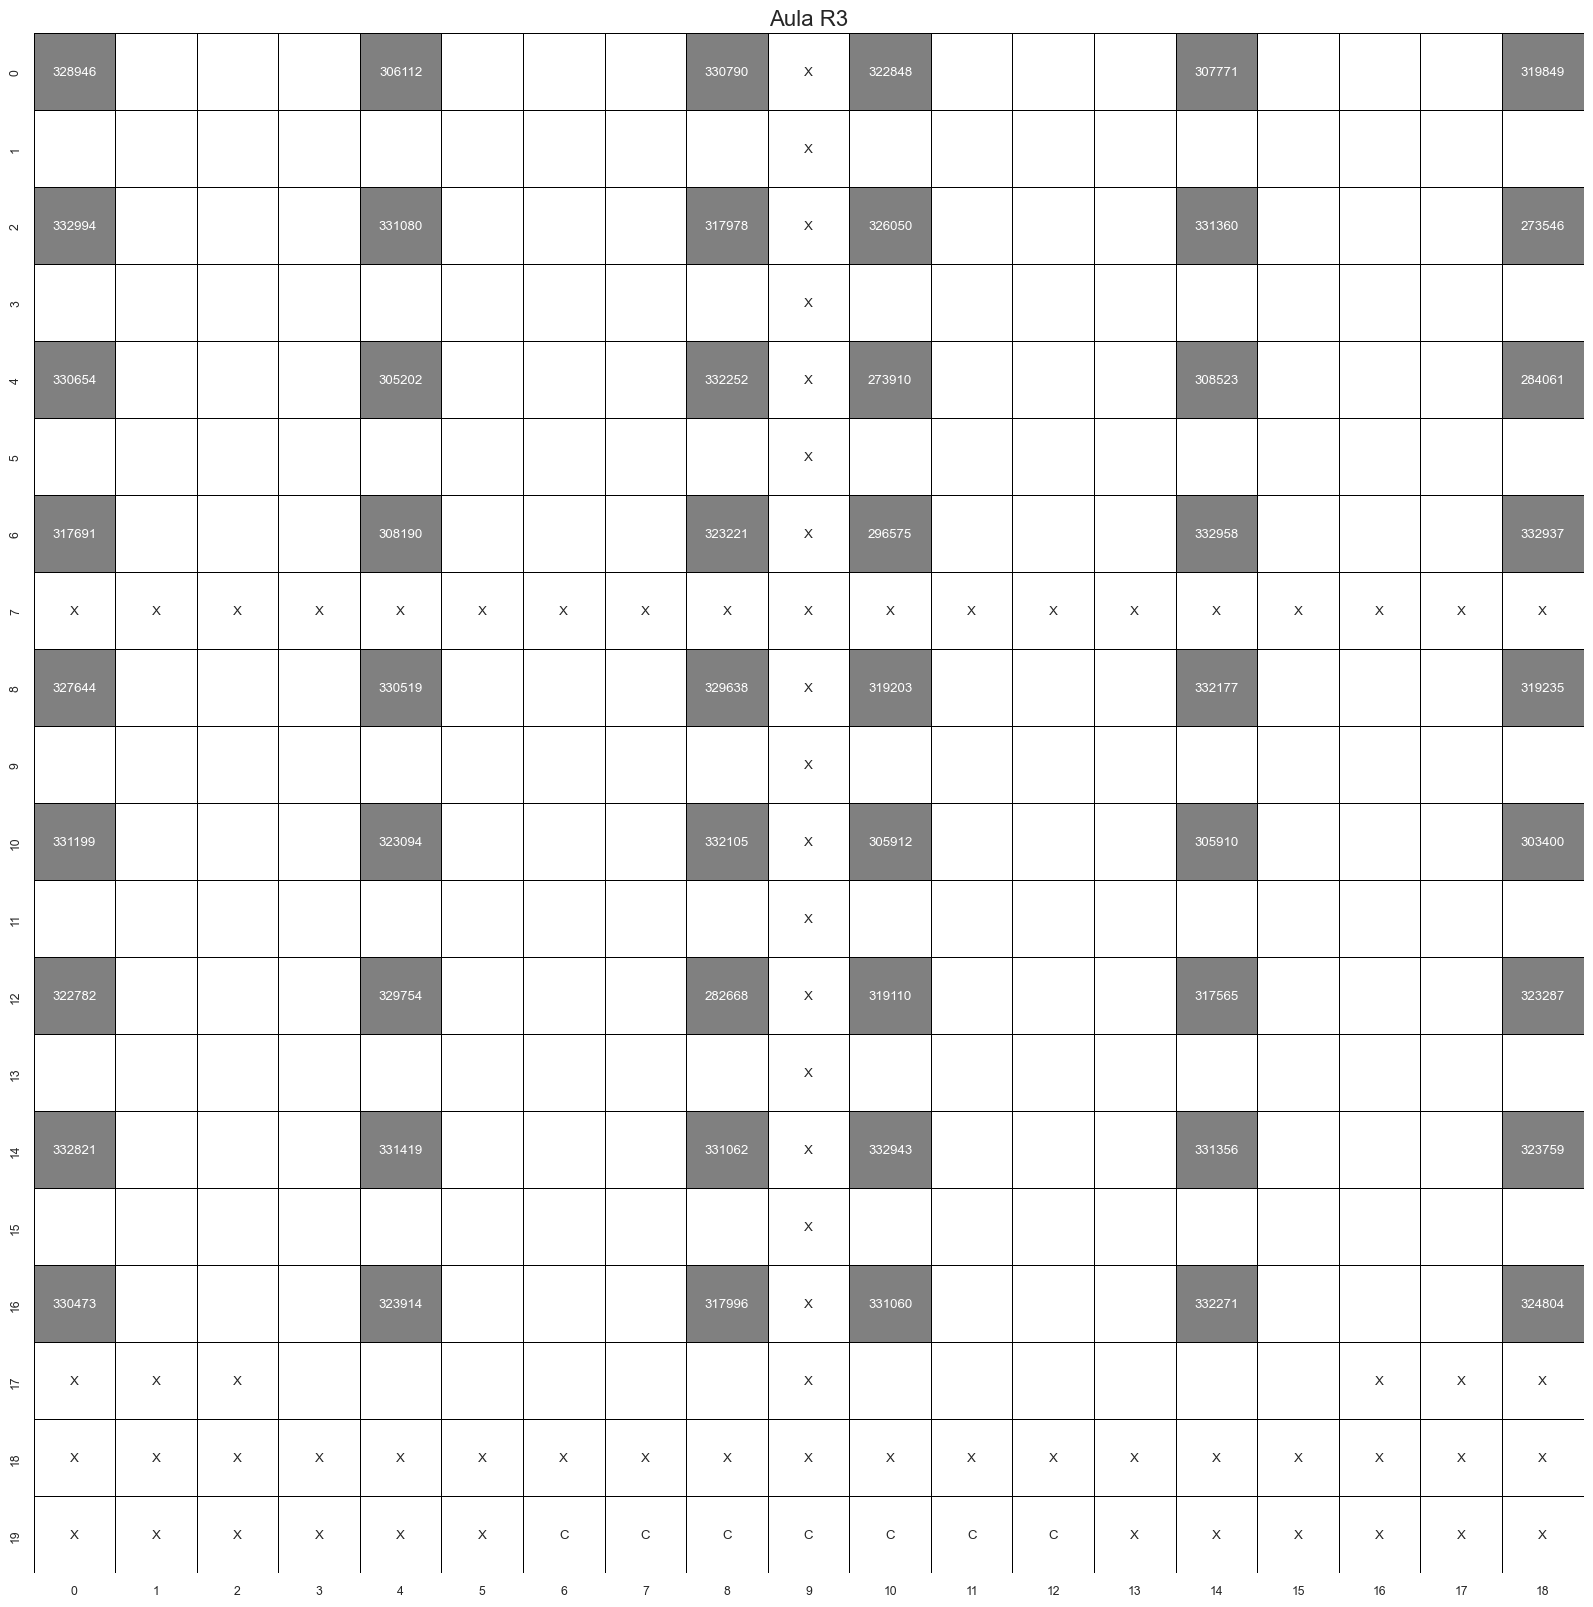

In [77]:
for k, v in rooms.items():
    plt.figure(figsize=(20, 10))
    ann = v.astype(str)
    for o, s in zip([-2, -1, 0], ["C", "X", ""]):
        ann[v == o] = s
    sns.heatmap(v, annot=ann, fmt="s", cmap=["white", "grey"], linecolor="black", linewidths=0.5, cbar=False)
    # Set title with font size 16
    plt.title(f"Aula {k}", fontsize=16)
    plt.savefig(f"{k}.png", dpi=300)